In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
from scipy.interpolate import interp1d #for smooth line plots
import sklearn.preprocessing as process

In [2]:
train_table = pd.DataFrame.from_csv('../data/subset_train_OHE.csv')
test_table = pd.DataFrame.from_csv('../data/subset_test_OHE.csv')

In [3]:
bidPredictionColumns = []
for i in range(52, 101):
    for column in train_table.columns.values:
        if column.endswith(str(i)) and column.startswith('bid'):
            bidPredictionColumns.append(column)

askPredictionColumns = []
for i in range(52, 101):
    for column in train_table.columns.values:
        if column.endswith(str(i)) and column.startswith('ask'):
            askPredictionColumns.append(column)

predictionColumns = bidPredictionColumns + askPredictionColumns

In [4]:
featureColumns = []
columnsToIgnore = ['row_id']
for column in train_table.columns.values:
    if ((column not in predictionColumns) and (column not in columnsToIgnore) and (not column.startswith('time'))):
        featureColumns.append(column)

In [5]:
'''import pickle
with open('../run_models/clusterAndClassify_RFC.model', 'r') as output: 
    clustering_model = pickle.load(output)'''

"import pickle\nwith open('../run_models/clusterAndClassify_RFC.model', 'r') as output: \n    clustering_model = pickle.load(output)"

In [13]:
all_bid_columns = []
for column in train_table.columns.values:
    if column.startswith('bid'):
        all_bid_columns.append(column)

all_ask_columns = []
for column in train_table.columns.values:
    if column.startswith('ask'):
        all_ask_columns.append(column)

In [15]:
all_bid_prices = np.array(train_table[all_bid_columns])
all_ask_prices = np.array(train_table[all_ask_columns])

In [16]:
all_bid_prices_nm = process.scale(all_bid_prices, axis=1)
all_ask_prices_nm = process.scale(all_ask_prices, axis=1)

-4058891.47102


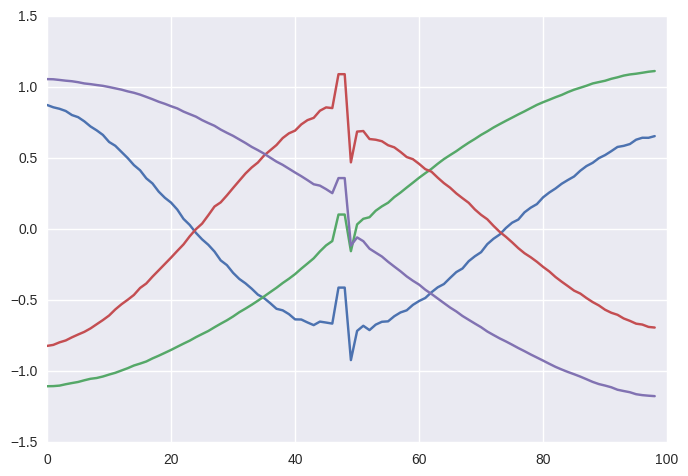

In [18]:
all_clusters = 4
all_bid_cluster_model = cluster.KMeans(n_clusters=all_clusters,
                                   init='k-means++',
                                   n_init=10,
                                   max_iter=300,
                                   tol=0.0001,
                                   precompute_distances='auto',
                                   verbose=0,
                                   random_state=None,
                                   copy_x=True,
                                   n_jobs=1)
all_bid_cluster_model.fit(all_bid_prices_nm)
print all_bid_cluster_model.score(all_bid_prices_nm)

all_bid_labels = all_bid_cluster_model.predict(all_bid_prices_nm)

for i in range(all_clusters):
    all_bid_cluster = all_bid_prices_nm[all_bid_labels == i, :]
    
    all_bid_cluster_mean = np.mean(all_bid_cluster, axis=0)
    x_axis = range(99)
    #print bid_cluster.shape
    plt.plot(x_axis, all_bid_cluster_mean)

-4055536.15414


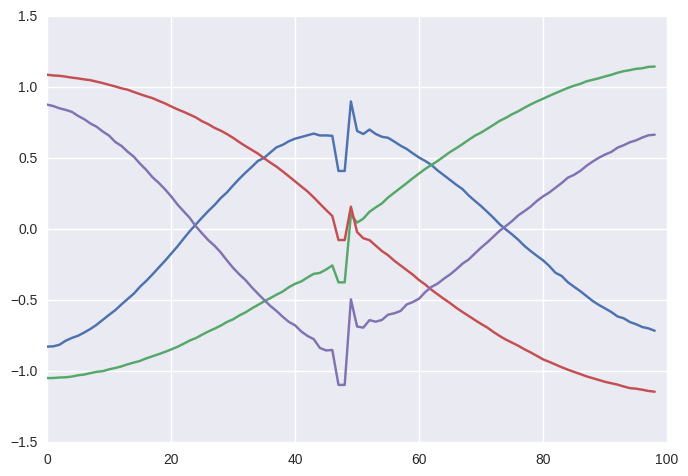

In [19]:
all_clusters = 4
all_ask_cluster_model = cluster.KMeans(n_clusters=all_clusters,
                                   init='k-means++',
                                   n_init=10,
                                   max_iter=300,
                                   tol=0.0001,
                                   precompute_distances='auto',
                                   verbose=0,
                                   random_state=None,
                                   copy_x=True,
                                   n_jobs=1)
all_ask_cluster_model.fit(all_ask_prices_nm)
print all_ask_cluster_model.score(all_ask_prices_nm)

all_ask_labels = all_ask_cluster_model.predict(all_ask_prices_nm)

for i in range(all_clusters):
    all_ask_cluster = all_ask_prices_nm[all_ask_labels == i, :]
    
    all_ask_cluster_mean = np.mean(all_ask_cluster, axis=0)
    x_axis = range(99)
    #print bid_cluster.shape
    plt.plot(x_axis, all_ask_cluster_mean)

In [22]:
import sklearn.ensemble as ensemble
import sklearn.multiclass as multiclass

In [23]:
trainX = np.zeros((train_table.shape[0], len(featureColumns)))

trainY_ask = np.zeros((train_table.shape[0]))
trainY_bid = np.zeros((train_table.shape[0]))

testX = np.zeros((test_table.shape[0], len(featureColumns)))

In [24]:
index = 0
for ix, row in train_table.iterrows():
    X = (np.array(row[featureColumns])).flatten('F')
    Y_bid = row[bidPredictionColumns[0]]
    Y_ask = row[askPredictionColumns[0]]
    
    trainX[index, :] = X
    trainY_ask[index] = Y_ask
    trainY_bid[index] = Y_bid
    
    index = index+1

In [25]:
index = 0
for ix, row in test_table.iterrows():
    X = (np.array(row[featureColumns])).flatten('F')
    testX[index, :] = X

    index = index+1

In [ ]:
bid_cluster_classifier = multiclass.OneVsOneClassifier(estimator=ensemble.AdaBoostClassifier(base_estimator=None,
                                                     n_estimators=50,
                                                     learning_rate=1.0,
                                                     algorithm='SAMME.R',
                                                     random_state=None), n_jobs=1)
bid_cluster_classifier.fit(trainX, all_bid_labels)
print "Bid accuracy: ", bid_cluster_classifier.score(trainX, all_bid_labels)

ask_cluster_classifier = multiclass.OneVsOneClassifier(estimator=ensemble.AdaBoostClassifier(base_estimator=None,
                                                     n_estimators=50,
                                                     learning_rate=1.0,
                                                     algorithm='SAMME.R',
                                                     random_state=None), n_jobs=1)
ask_cluster_classifier.fit(trainX, all_ask_labels)
print "Ask accuracy: ", ask_cluster_classifier.score(trainX, all_ask_labels)

Bid accuracy:  0.487707387866


In [ ]:
models_bid = []
models_ask = []
for i in range(all_clusters):
    model_ask = lm.LinearRegression(fit_intercept=True, normalize=False, n_jobs=1)
    model_ask.fit(trainX[all_ask_labels == i, :], trainY_ask[all_ask_labels == i])
    models_ask.append(model_ask)
    
    model_bid = lm.LinearRegression(fit_intercept=True, normalize=False, n_jobs=1)
    model_bid.fit(trainX[all_bid_labels == i, :], trainY_bid[all_bid_labels == i])
    models_ask.append(model_bid)

In [ ]:
testX_ask_labels = ask_cluster_classifier.predict(testX)
testX_bid_labels = bid_cluster_classifier.predict(testX)

In [ ]:
testY_ask = np.zeros((textX.shape[0]))
testY_ask = np.zeros((textX.shape[0]))

In [ ]:
for i in range(all_clusters):
    testY_ask[testX_ask_labels == i] = models_ask[i].predict(testX[testX_ask_labels == i, :])
    testY_bid[testX_bid_labels == i] = models_bid[i].predict(testX[testX_bid_labels == i, :])

In [ ]:
prediction = pd.DataFrame.from_csv('../predictions/template_prediction.csv')

i = 0
for ix, row in test_table.iterrows():
    row_id = row['row_id']

    index_in_pred = prediction[prediction['row_id'] == row_id].index.tolist()[0]

    bid = testY_bid[i]
    ask = testY_ask[i]
    i = i+1
    
    for column in predictionColumns:
        if column.startswith('bid'):
            prediction.set_value(index_in_pred, column, bid)
        else:
            prediction.set_value(index_in_pred, column, ask)